In [3]:
#%matplotlib widget #need this for click GUIs
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt
from chipcalibration import chevron as ch
from importlib import reload
import qubic.state_disc as sd
import chipcalibration.config as cfg

In [4]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = cfg.load_configs(qchipname)
chanmap = {'Q0':7,'Q2':1,'Q1':4,'Q3':3,'Q4':5,'Q5':6,'Q6':2}


In [5]:
reload(rc)
runner = rc.CircuitRunnerClient(ip='192.168.1.247')

In [6]:
reload(ch)
qubits = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
nwidth = 40
pulse_widths = np.linspace(4.e-9, 40*4.e-9, nwidth)
nfreq = 50
chevron = ch.Chevron(qubits, 20.e6, nfreq, pulse_widths, qchip, fpga_config, channel_config)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

In [7]:
chevron.circuits

[[{'name': 'rabi',
   'qubit': ['Q0'],
   'modi': {(0, 'twidth'): 4e-09, (0, 'fcarrier'): 4448076421.116688}},
  {'name': 'read', 'qubit': ['Q0']},
  {'name': 'rabi',
   'qubit': ['Q1'],
   'modi': {(0, 'twidth'): 4e-09, (0, 'fcarrier'): 4663715124.585349}},
  {'name': 'read', 'qubit': ['Q1']},
  {'name': 'rabi',
   'qubit': ['Q2'],
   'modi': {(0, 'twidth'): 4e-09, (0, 'fcarrier'): 4934328462.654274}},
  {'name': 'read', 'qubit': ['Q2']},
  {'name': 'rabi',
   'qubit': ['Q3'],
   'modi': {(0, 'twidth'): 4e-09, (0, 'fcarrier'): 5115000000.0}},
  {'name': 'read', 'qubit': ['Q3']},
  {'name': 'rabi',
   'qubit': ['Q4'],
   'modi': {(0, 'twidth'): 4e-09, (0, 'fcarrier'): 5340927547.979777}},
  {'name': 'read', 'qubit': ['Q4']},
  {'name': 'delay', 't': 0.0004, 'qubit': ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']},
  {'name': 'rabi',
   'qubit': ['Q0'],
   'modi': {(0, 'twidth'): 4e-09, (0, 'fcarrier'): 4448484584.381994}},
  {'name': 'read', 'qubit': ['Q0']},
  {'name': 'rabi',
   'qubit': ['Q1'],
   

In [19]:
chevron.run(runner, 100)

In [7]:
debug

> /usr/lib/python3/dist-packages/numpy/core/fromnumeric.py(43)_wrapit()
     41     except AttributeError:
     42         wrap = None
---> 43     result = getattr(asarray(obj), method)(*args, **kwds)
     44     if wrap:
     45         if not isinstance(result, mu.ndarray):

ipdb> up
> /usr/lib/python3/dist-packages/numpy/core/fromnumeric.py(54)_wrapfunc()
     52     bound = getattr(obj, method, None)
     53     if bound is None:
---> 54         return _wrapit(obj, method, *args, **kwds)
     55 
     56     try:

ipdb> up
> /usr/lib/python3/dist-packages/numpy/core/fromnumeric.py(660)transpose()
    658 
    659     """
--> 660     return _wrapfunc(a, 'transpose', axes)
    661 
    662 

ipdb> up
> <__array_function__ internals>(5)transpose()

ipdb> up
> /home/xilinx/jupyter_notebooks/chipcalibration/chipcalibration/chevron.py(59)run()
     57         self.s11 = circuit_runner.run_circuit_batch(self.raw_asm_progs, nsamples, len(self.freqoffsets), 
     58                         

In [9]:
reload(sd)
gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_config)

In [10]:
gmm.fit(chevron.s11)
chevron.s11['3'].shape

(40, 50, 100)

In [11]:
result = gmm.predict(chevron.s11)

In [12]:
gmm.set_labels_maxtomin({chan: shots[0].flatten() 
                                      for chan, shots in chevron.s11.items()}, [0, 1])

In [13]:
state_disc_shots = gmm.predict(chevron.s11)

In [14]:
ones_frac = {qubit: np.sum(state_disc_shots[qubit], axis=2) for qubit in state_disc_shots.keys()}

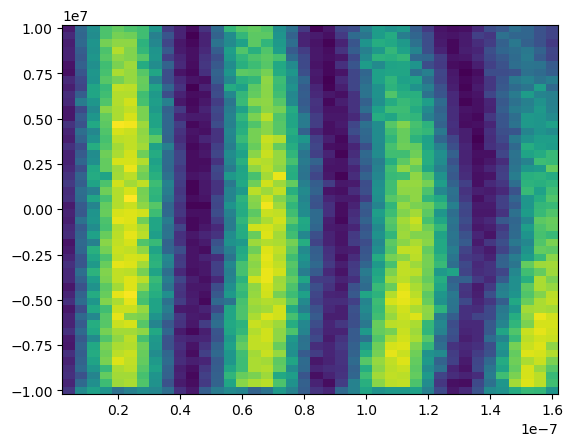

In [15]:
plt.pcolormesh(chevron.pulse_widths, chevron.freqoffsets, ones_frac['Q3'].T)

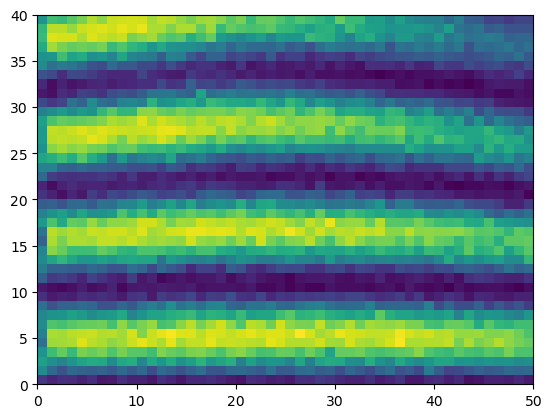

In [16]:
plt.pcolormesh(chevron.ones_frac['Q3'])

In [17]:
plt.pcolormesh?